# Recommendations with IBM


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_test as t
import pickle
from pandas_profiling import ProfileReport

In [3]:
df = pd.read_csv('user-item-interactions.csv')
df_content = pd.read_csv('articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In [5]:
#Profiling Report 1
profile=ProfileReport(df,title="profiling report",explorative=True)
profile.to_file("df.html")

#Profiling Report 2
profile=ProfileReport(df_content,title="profiling report",explorative=True)
profile.to_file("df_content.html")

In [6]:
df.email.value_counts()

2b6c0f514c2f2b04ad3c4583407dccd0810469ee    364
77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a    363
2f5c7feae533ce046f2cb16fb3a29fe00528ed66    170
a37adec71b667b297ed2440a9ff7dad427c7ac85    169
8510a5010a5d4c89f5b07baac6de80cd12cfaf93    160
                                           ... 
53d268dcfbc1f30244f7d9451dc198f37aa293d1      1
fd2d1d1e93e0b1296a2f24d8707aa78999ee0925      1
33e9ddcc2d577781c3e13ad2bc24bf887209d782      1
3fac88958dc7903b380743597f44a79cf76ea128      1
c4efd9572418bed9e3129a803489a45173d95a82      1
Name: email, Length: 5148, dtype: int64

In [7]:
np.percentile(df.email.value_counts(),50)

3.0

In [8]:
# Fill in the median and maximum number of user_article interactios below

median_val = np.percentile(df.email.value_counts(),50) # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Display duplicate rows
df_content[df_content.article_id.duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [10]:
# Remove duplicate rows
print(df_content.shape)

df_content=df_content[~df_content.article_id.duplicated()]

print('\n',df_content.shape)

(1056, 5)

 (1051, 5)


In [11]:
# unique_articles
df.article_id.nunique()

714

In [12]:
# total_articles
df_content.article_id.nunique()

1051

In [13]:
# unique_users
df.email.nunique()

5148

In [14]:
# number of user-article interactions
df.shape[0]

45993

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 #The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
df.article_id=df.article_id.astype(str)

In [17]:
df.email.groupby(df.article_id).size().sort_values(ascending=False)

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
         ... 
1092.0      1
1266.0      1
1072.0      1
1233.0      1
1200.0      1
Name: email, Length: 714, dtype: int64

In [18]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [19]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [20]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

In [21]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
        
    top_articles=list(df.title.value_counts().index)[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''

    top_articles=list(df.article_id.value_counts().index)[:n]
    
    return top_articles # Return the top article ids

In [22]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* If a user has interacted with an article, then place a 1 where the user-row meets for that article-column.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* If a user has not interacted with an item, then place a zero where the user-row meets for that article-column.

In [23]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item=pd.pivot_table(df,index='user_id',aggfunc=np.max,columns='article_id',fill_value=0)
    
    for i in range(user_item.shape[0]):
        for j in range(user_item.shape[1]):
            if user_item.iloc[i,j]!=0:
                user_item.iloc[i,j]=1
    
    # Drop multi-level index
    user_item.columns = user_item.columns.droplevel()
    
    # Convert datatype of columns from str to int
    for i in user_item.columns:
        user_item[i]=user_item[i].astype(int)
        
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [24]:
user_item.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [26]:
# create the user-article dictionary

def create_user_article_dict():
    '''
    INPUT: None
    OUTPUT: user_dict - a dictionary where each key is a user_id and the value is an array of articles interacted with.
    
    Creates the movies_seen dictionary
    '''
       
    # create a dictionary where the key is each user and the value is list of 'article_id' that user has interacted with.
    user_dict={}
    for row in user_item.index.values:
        temp_list=[]
        for col in list(user_item.columns):
            if user_item.loc[row,col]>0:
                temp_list.append(col)
        user_dict[row]=temp_list
    
    return user_dict # return the user_item dictionary

user_dict = create_user_article_dict()

In [27]:
# create the user-user matrix that holds number of common articles between each pair of users.

def create_user_user_matrix():
    '''
    INPUT: None
    OUTPUT: user_user_ - a dictionary where each key is a user_id and the value is an array of articles interacted with.
    
    Creates the movies_seen dictionary
    '''
    
    # Create a dataframe that holds number of common articles between each pair of users
    user_user_matrix=pd.DataFrame(data=np.zeros((user_item.shape[0],user_item.shape[0])),columns=user_item.index)

    for i in list(user_item.index):
        for j in list(user_item.index):
            user_user_matrix.loc[i,j]=len(np.intersect1d(user_dict[i],user_dict[j],assume_unique=True))
    
    return user_user_matrix # return the user_user matrix

#user_user_matrix = create_user_user_matrix()
#user_user_matrix.to_pickle('user_common_article')

In [28]:
user_user_matrix=pd.read_pickle('user_common_article')
user_user_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,5140,5141,5142,5143,5144,5145,5146,5147,5148,5149
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36.0,2.0,6.0,3.0,0.0,4.0,1.0,6.0,4.0,7.0,...,7.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,6.0,1.0,3.0,0.0,2.0,0.0,1.0,2.0,4.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6.0,1.0,40.0,5.0,1.0,7.0,1.0,5.0,2.0,5.0,...,7.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0
4,3.0,3.0,5.0,26.0,3.0,8.0,0.0,8.0,1.0,4.0,...,6.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0


In [29]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    most_similar_users=list(user_user_matrix[user_id].sort_values(ascending=False).index)[1:]
    
    return most_similar_users # return a list of the users in order from most to least similar        

In [30]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [3933, 3782, 23, 4459, 203]
The 3 most similar users to user 46 are: [4201, 23, 3782]


#### Now that we have a function that provides the most similar users to each user, we will use these users to find articles that can be recommended.

In [31]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names=list(df[df.article_id.isin(article_ids)].title.groupby(df.title).size().index.values)
          
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    article_ids=user_dict[user_id]
        
    article_names=get_article_names(article_ids)
        
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    art=[]
    for i in find_similar_users(user_id):
        art.extend(np.setdiff1d(user_dict[i],user_dict[user_id]))
        if len(set(art))>m:
            break
    recs=list(set(art[:m+1]))
    
    return recs # return your recommendations for this user_id    

In [32]:
# Check Results
get_article_names(user_user_recs(2, 10)) # Return 10 recommendations for user 1

['a comparison of logistic regression and naive bayes ',
 'access mysql with python',
 'analyze accident reports on amazon emr spark',
 'analyze energy consumption in buildings',
 'analyze open data sets with pandas dataframes',
 'analyze open data sets with spark & pixiedust',
 'analyze precipitation data',
 'analyzing data by using the sparkling.data library features',
 'apache spark lab, part 3: machine learning',
 'mapping points with folium',
 'tidy up your jupyter notebooks with scripts']

In [33]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


Now we are going to improve the consistency of the **user_user_recs** function from above.

Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we will choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be what would be obtained from the **top_articles** function.

In [34]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    '''
    
    The logic by which I have derived similar users in function "find_similar_users" takes care of 
    this condition as well.
    The logic retuens the similar users sorted by the number of interactions and overlapping items where 
    highest of each is higher in the dataframe.
    
    '''
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    rec_names=list(df[df.article_id.isin(user_user_recs(user_id))].title.value_counts().index)
    recs= list(set(df[df.title.isin(rec_names)].article_id.values))
    
    return recs, rec_names

In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(2, 10)
print("The top 10 recommendations for user 2 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 2 are the following article names:")
print(rec_names)

The top 10 recommendations for user 2 are the following article ids:
['1164.0', '1166.0', '111.0', '1053.0', '1165.0', '1160.0', '1047.0', '1172.0', '1163.0', '1162.0', '1044.0']

The top 10 recommendations for user 2 are the following article names:
['analyze energy consumption in buildings', 'analyze accident reports on amazon emr spark', 'analyze precipitation data', 'apache spark lab, part 3: machine learning', 'analyze open data sets with spark & pixiedust', 'analyze open data sets with pandas dataframes', 'access mysql with python', 'analyzing data by using the sparkling.data library features', 'a comparison of logistic regression and naive bayes ', 'tidy up your jupyter notebooks with scripts', 'mapping points with folium']


In [36]:
def all_recommendations():
    '''
    INPUT 
        num_recs (int) the (max) number of recommendations for each user
    OUTPUT
        all_recs - a dictionary where each key is a user_id and the value is an array of recommended movie titles
    '''
    all_recs={}
    for i in list(user_user_matrix.columns):
        all_recs[i]=user_user_recs_part2(i)[0]
      
    return all_recs

all_recs = all_recommendations()

In [37]:
all_recs[4]

['1185.0',
 '1164.0',
 '111.0',
 '1053.0',
 '1165.0',
 '1174.0',
 '1047.0',
 '1176.0',
 '1172.0',
 '1163.0',
 '1044.0']

In [38]:
# Check for users with no recommendations
no_recs=[]
for i,v in all_recs.items():
    if len(v)==0:
        no_recs.append(i)
no_recs

[]

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [39]:
print(find_similar_users(1)[0])
print(find_similar_users(131)[10])

3933
242


In [40]:
### Tests with a dictionary of results

user1_most_sim = 3933
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [41]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**
* I would use the Rank based recommendation system to recommend top articles

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [42]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

In [43]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [44]:
# Load the matrix here
#user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [58]:
# quick look at the matrix
user_item.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [60]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item,full_matrices=False)

In [61]:
s1=np.diag(s)
u.shape,s1.shape,vt.shape

((5149, 714), (714, 714), (714, 714))

##### Provide the Reason
There are no missing values in the data so traditional SVD didn't break and converged.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

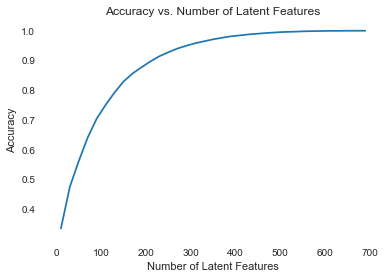

In [62]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [63]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    user_item_train=create_user_item_matrix(df_train)
    
    user_item_test=create_user_item_matrix(df_test)
    
    test_idx=user_item_test.index.values
    
    test_arts=user_item_test.columns.values
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [64]:
len(np.setdiff1d(user_item_test.index, user_item_train.index))

662

In [65]:
len(np.intersect1d(test_idx, user_item_train.index))

20

In [66]:
len(np.intersect1d(user_item_test.columns, user_item_train.columns))

574

In [67]:
len(np.setdiff1d(user_item_test.columns, user_item_train.columns))

0

In [68]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a , 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [84]:
# Number of rows in user_item_test for which prediction can be made
len(np.intersect1d(test_idx, user_item_train.index))

20

In [85]:
# Rows in dataset user_item_test for which prediction can be made
user_item_train[user_item_train.index.isin(list(np.intersect1d(test_idx, user_item_train.index)))]

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3532,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3684,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train,full_matrices=False)
s_train_1=np.diag(s_train)
u_train.shape, s_train_1.shape, vt_train.shape

((4487, 714), (714, 714), (714, 714))

# Fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

In [167]:
# Users and articles in user_item_train matrix
train_idx = np.array(user_item_train.index)
train_arts = np.array(user_item_train.columns)

# Users and articles of test set in training set
test_idx_set = np.intersect1d(test_idx, train_idx)
test_arts_set = np.intersect1d(test_arts, train_arts)

# Users and articles positions of test subset in training matrix
train_indexes = np.where(np.in1d(train_idx, test_idx_set))[0]
train_articles = np.where(np.in1d(train_arts, test_arts_set))[0]

# Users positions of test subset in test matrix
test_indexes = np.where(np.in1d(test_idx, test_idx_set))[0]

In [168]:
# FIND SUBSET OF USER_ITEM MATRIX CONTAINING ONLY USER AND ARTICLES THAT ARE SHARED BY TRAIN AND TEST SET
u_item_test_set = user_item_test.iloc[test_indexes,:]
u_item_train_set = user_item_train.iloc[train_indexes, train_articles]

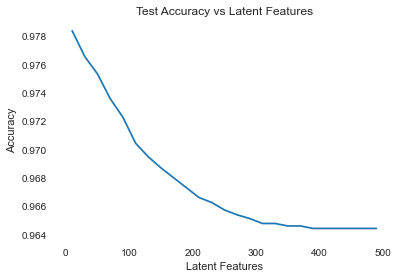

In [169]:
num_latent_feats = np.arange(10, 500, 20)
sum_errs = []

for k in num_latent_feats:
    
    # Restructure train matrices using k features
    s_train_k, u_train_k, vt_train_k = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
        
    # Restructure test matrices using k features
    s_test_k, u_test_k, vt_test_k = s_train_k, u_train_k[train_indexes,:], vt_train_k[:,train_articles]
    
    # Calculate dot product
    u_item_test_set_pred = np.around(np.dot(np.dot(u_test_k, s_test_k), vt_test_k))
    
    # Error (prediction - actual values)
    error = np.subtract(u_item_test_set, u_item_test_set_pred)
    
    # Total errors
    total_error = np.sum(np.sum(np.abs(error)))
    sum_errs.append(total_error)
    

# Plot test accuracy and latent features
n_interactions_set = u_item_test_set.shape[0] * u_item_test_set.shape[1]
plt.plot(num_latent_feats, 1 - np.array(sum_errs) / n_interactions_set);
plt.xlabel('Latent Features');
plt.ylabel('Accuracy');
plt.title('Test Accuracy vs Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**
The accuracy in the test set decreases as latent features increases. This could be probably because of very less number of rows (20) in the test data set.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [170]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0